# Imports

In [5]:
import os
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import regex
import glob
import time
import itertools
from collections import namedtuple
import collections
import copy
from scipy.spatial import distance
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from math import sqrt
from sys import stderr
from numpy import linalg
import networkx as nx
import re
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from utils.Hypersphere import fit_hypersphere
from utils.read_msms import read_msms
from Bio.PDB.ResidueDepth import ResidueDepth
from Bio.PDB.PDBParser import PDBParser
from sklearn.preprocessing import StandardScaler
from scipy.spatial import Delaunay, ConvexHull
import pickle
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans, vq
import scipy.cluster.hierarchy as sch
from collections import OrderedDict
import subprocess
import unittest

SMALL_SIZE = 10
MEDIUM_SIZE = 13
BIGGER_SIZE = 13

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams.update({'figure.autolayout': True})

# Defining the Input and the Output Folder Name

In [6]:
input_folder_name = 'Protein-inhibitor'
output_folder_name = 'output_protein-ligand'
path = Path(os.path.abspath('./data/'))
sub_path = Path(os.path.abspath('./data/'+input_folder_name))
OUTPUT = output_folder_name
try:
    os.mkdir(os.path.expanduser(path/OUTPUT))
    # this is making the directory of that name
except FileExistsError:
    print("it exists")
    
df_of_dms_files = pd.DataFrame(columns=['file_id','file_path'])
for files in glob.glob(sub_path.as_posix()+"/*.dms"): #gets files having .dms extension in the said directory
    filename = files
    if filename in list(df_of_dms_files['file_path']):
        break
    else:
        structure_id = regex.search(
            r"(?:.+[/\\])(.+)(?:\.dms)", filename).group(1) 
        s1 = structure_id #s1 becomes structure ID
        new_df = pd.DataFrame({'file_id':[s1],'file_path':[filename]})
        df_of_dms_files = pd.concat([df_of_dms_files,new_df],ignore_index=True)

it exists


In [55]:
def write_pdb_X_file(filename,s1):

    with open(filename, 'r') as f:
        k = f.read()
    # pattern is created by the compile function in re
    pattern = re.compile(r"(.{20,})(?:\bA\b)", flags=re.M | re.I)
    pattern2 = re.compile(r"(.{20,})(?:\bS\w+\b)(.+)", flags=re.M)
    
    l1 = pattern.findall(k) #k which is the filename, we are finding whether the characters that are defined by the pattern are found
    l2 = pattern2.findall(k)
    iterables1 = {}
    iterables_orig = {}
    iterables_normal_area = {}

    for x, y in l2:
        search = regex.search(
            r"(\w{,3})\s*(\w+)(?:\*?)\s*(\w+)(?:\*|'?)\s*(-?\d+\.\d+)\s*(-?\d+\.\d+)\s*(-?\d+\.\d+)", x)
        iterables1[tuple(map(float, [search.group(4), search.group(5), search.group(6)]))] = [
            x, list(map(float, y.split()[:]))]
        
    

    for x in l1:
        search = regex.search(
            r"(\w{,3})\s*(\w+)(?:\*?)\s*(\w+)(?:\*|'?)\s*(-?\d+\.\d+)\s*(-?\d+\.\d+)\s*(-?\d+\.\d+)", x)
        iterables_orig[tuple(
            map(float, [search.group(4), search.group(5), search.group(6)]))] = [x]
    pattern_new = regex.compile(
        r"(\w{3})\s*(\w+)\s*(\w+)\s*(-?\d+\.\d+)\s*(-?\d+\.\d+)\s*(-?\d+\.\d+)")
    data = np.array([x for x in iterables1.keys()])
    data = np.array(data, 'float64')
    Z = linkage(data, 'complete')  # ward --> complete
    max_d = 13  # patch
    clusters = fcluster(Z, max_d, criterion='distance')
    curvature = collections.defaultdict(list)
    centroid = np.median(data, axis=0)
    with open(os.path.expanduser(path.as_posix()+'/%s/%s_%s.pdb' % (OUTPUT, s1, 'X')), 'w') as f:
        dist = []
        j = 0
        for i in range(1, max(clusters)+1):
            curv1_p = []
            curv2_p = []
            curv_m = fit_hypersphere(data[clusters == i])
            ci = curv_m[1]
            count = []
            d_centroid = np.linalg.norm(centroid-ci)

            for x in data[clusters == i]:

                d = np.linalg.norm(ci-x)
                d_c = np.linalg.norm(centroid-x)
                if d_c > d_centroid:
                    # if d>curv_m[0]:
                    count.append(1)
                    
                    curv1_p.append(x)
                else:
                    count.append(-1)
                    curv2_p.append(x)

            A = (len(curv1_p)/len(data[clusters == i]))
            B = (len(curv2_p)/len(data[clusters == i]))
            for x in curv1_p:
                curvature[tuple(x)] = A*100/curv_m[0]**1
            for x in curv2_p:
                curvature[tuple(x)] = B*-100/curv_m[0]**1  # put - sign

    j = 0
    # j is a line
    with open(os.path.expanduser(path.as_posix()+'/%s/%s_%s.pdb' % (OUTPUT, s1, 'X')), 'w') as f:
        for _, x in enumerate(curvature.keys()):

            loc1 = iterables1[tuple(x)]
            loc = loc1[0].split()
            print("{:6s}{:5d} {:^4s}{:1s}{:3s} {:1s}{:4d}{:1s}     {:8.3f}  {:8.3f}  {:8.3f}  {:6.2f}  {:6.2f}          {:>2s}{:2s}".format("ATOM", j, "A", " ", loc[0], "X", 
                                                                                                                                  int(loc[1].rstrip(regex.search(r'(\d+)(.*)',
                                                                                                                                  loc[1]).group(2))), '', 
                                                                                                                                  x[0], x[1], x[2], loc1[1][0], 
                                                                                                                                  curvature[tuple(x)], '', loc[2]), file=f)

            j += 1

    dist = [curvature[x] for x in curvature]
    dist = np.array(dist)
    dots = len(dist)
    plt.figure()
    plt.xlabel(
        "Curvature($\kappa$)\n$\longleftarrow$ concave | convex $\longrightarrow$")
    plt.ylabel("number of surface points")
    plt.title('%s %s:Number of surface points: %d\nScaling factor: 100*$\kappa$' %
              (s1.upper(), "", len(dist)))

    plt.hist(dist, bins=15, color='gray', alpha=0.8)
    plt.savefig(os.path.expanduser(path.as_posix()+'/%s/%s_%s_%s hist.jpeg' %
                                   (OUTPUT, dots, s1, 'X')), format='jpeg', dpi=300)
    plt.show()

# Creating the final Histogram of Shape Complimentarity

In [56]:
def generate_the_complimentarity_plot():
    pdb_id = collections.defaultdict(list)
    dms_id = collections.defaultdict(list)
    dms_path = os.path.expanduser(sub_path.as_posix()+"/*.dms")
    column_list = [i for i in range(12)]

    for files in glob.glob(dms_path):
        filename = files
        structure_id = regex.search(
            r"(?:.+[/\\])(.+)(?:\.dms)", filename, flags=regex.I).group(1)
        s1 = structure_id
        dms_id[structure_id].append(filename)

    dms_normal = {}
    for name_dms in dms_id:
        with open(dms_id[name_dms][0], 'r') as f:
            k = f.read()
        
        pattern = re.compile(r"(.{20,})(?:\bA\b)", flags=re.M | re.I)
        pattern2 = re.compile(r"(.{20,})(?:\bS\w+\b)(.+)", flags=re.M)
        l1 = pattern.findall(k)
        l2 = pattern2.findall(k)
        iterables1 = {}
        iterables_orig = {}
        iterables_normal_area = {}
        for x, y in l2:
            search = regex.search(
                r"(\w{,3})\s*(\w+)(?:\*?)\s*(\w+)(?:\*|'?)\s*(-?\d+\.\d+)\s*(-?\d+\.\d+)\s*(-?\d+\.\d+)", x)
            iterables1[tuple(map(float, [search.group(4), search.group(
                5), search.group(6)]))] = list(map(float, y.split()[1:]))
        dms_normal[name_dms] = copy.deepcopy(iterables1)

    for files in glob.glob((path/OUTPUT).as_posix()+"/*.pdb"):
        filename = files
        structure_id = regex.search(r"(?:.+/)(.{4})(?:.*_X\.pdb)", filename).group(1)
        pdb_id[structure_id].append(filename)


    for name_pdb in pdb_id:
        for i in itertools.combinations(pdb_id[name_pdb], 2):
            iterables = {}
            k = pd.read_csv(str(i[0]),names=column_list,sep='\s+')
            arr1 = []
            arr1_norm = []
            if(regex.search(r"_lig_X", i[0])):
                suffix = "_lig"
            else:
                suffix = ""
            for x in range(len(k)):
                #value you need  = k.iloc[x][10]
                #x[30:38].replace(" ", "") replace by k.iloc[x][6]
                #x[38:46] replace by k.iloc[x][7]
                #x[46:54] k.iloc[x][8]
                #x[60:66] k.iloc[x][10]
                iterables.setdefault(k.iloc[x][10], []).append(list(map(float, [k.iloc[x][6],
                                                                                k.iloc[x][7],
                                                                                k.iloc[x][8]])))
                arr1.append(list(map(float, [k.iloc[x][6],
                                             k.iloc[x][7],
                                             k.iloc[x][8], 
                                             k.iloc[x][10]])))
                arr1_norm.append(dms_normal[name_pdb+suffix][tuple(map(float, [k.iloc[x][6],
                                                                               k.iloc[x][7],
                                                                               k.iloc[x][8]]))])

            k1 = pd.read_csv(str(i[1]),sep='\s+',names=column_list)
            

            iterables1 = {}
            arr2 = []
            arr2_norm = []
            if(regex.search(r"_lig_X", i[1])):
                suffix = "_lig"
            else:
                suffix = ""
            for x in range(len(k1)):
                iterables1.setdefault(k1.iloc[x][10], []).append(list(map(float, [k1.iloc[x][6],
                                                                                k1.iloc[x][7],
                                                                                k1.iloc[x][8]])))
                arr2.append(list(map(float, [k1.iloc[x][6],
                                             k1.iloc[x][7],
                                             k1.iloc[x][8], 
                                             k1.iloc[x][10]])))                
                arr2_norm.append(dms_normal[name_pdb+suffix][tuple(map(float, [(k1.iloc[x][6]),
                                                                               (k1.iloc[x][7]),
                                                                               (k1.iloc[x][8])]))])                                                                 
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    arr1_norm = np.array(arr1_norm)
    arr2_norm = np.array(arr2_norm)
    normal_product = np.dot(arr2_norm, arr1_norm.T)

    arr_dist = distance.cdist(
        arr2[:, (0, 1, 2)], arr1[:, (0, 1, 2)], 'euclidean')

    new_dist = np.exp(-1*(arr_dist-np.mean(arr_dist, axis=0))
                      ** 2/(2*np.var(arr_dist, axis=0)))

    new_curv = distance.cdist(arr2[:, (3,)], -1*arr1[:, (3,)], 'cityblock')
    dat_new = (np.multiply(new_curv, new_dist)).flatten()
    plt.figure(dpi=300)

    plt.xlabel("shape complementarity")
    plt.ylabel("Number density")
#     numpy.histogram(dat_new, bins=20, density=True)
    plt.hist(dat_new, bins=20, density=True, color='gray', alpha=0.8)
    plt.title("%s_%s" % (name_pdb, "_lig"))
    plt.show()
    plt.savefig(path.as_posix()+"/%s_%s_plot.jpeg" %
                (name_pdb, "_lig"), format='jpeg', dpi=300)
    plt.close()


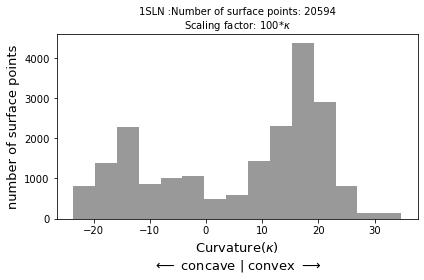

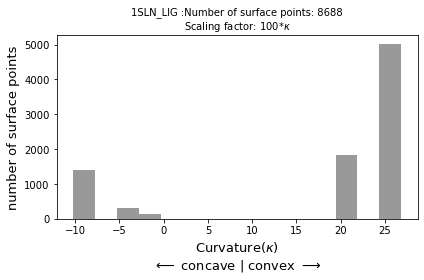

In [57]:
for i in range(2):
    filename = df_of_dms_files.iloc[i][1]
    s1 = df_of_dms_files.iloc[i][0]
    write_pdb_X_file(filename=filename,s1=s1)
    time.sleep(2)

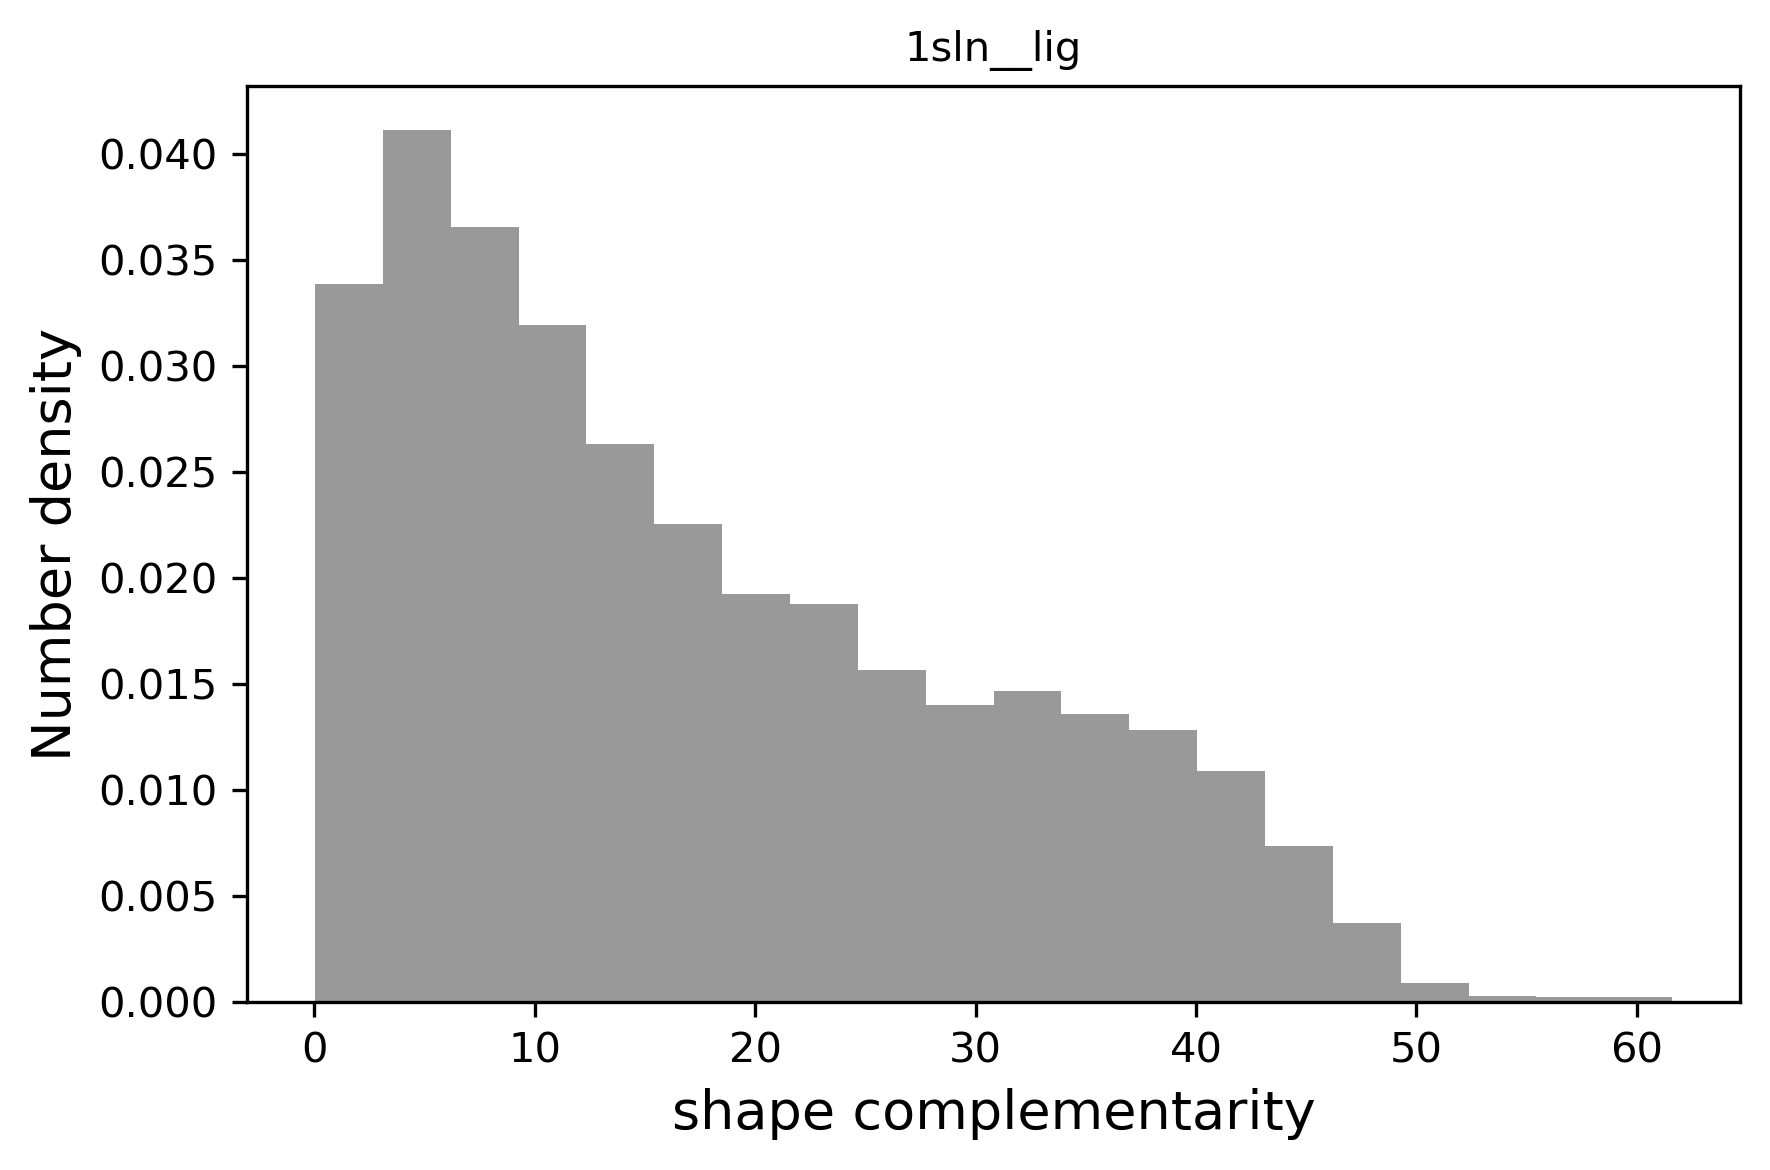

In [58]:
generate_the_complimentarity_plot()
